In [2]:
# Sarcini:
#  - Scrierea și comentarea codului.
#  - Implimentarea rețelei neuronale.


#Important imports
from numpy.core.fromnumeric import argmax
import torch
from torch import nn as nn
from torch.utils.data import Dataset,DataLoader
from torch import optim 
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from torch.nn import functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms,models


# matplotlib
import matplotlib.pyplot as plt

#Choosing devide to be gpu if have one, else cpu
DEVICE = torch.device( "cpu")  ##
print(DEVICE)

c:\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


cpu


In [3]:
#Loading data from folders
train_data = ImageFolder('data/training_set/training_set')
test_data = ImageFolder('data/test_set/test_set')

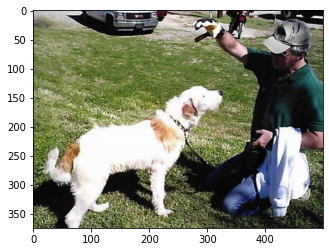

In [4]:
#Displaing one of the images, transforming it to tensor and then change so that color channel be last one
plt.imshow(transforms.ToTensor()(train_data[5445][0]).permute(1, 2, 0))

In [5]:
#Implementing Dataset class
class Data(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index]
        image = self.transform(image)
        return image, label

In [6]:
#Creating some basic tranfomration pipelines

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

transform_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(1),
    transforms.ToTensor()
])

In [7]:
train_dataset = Data(train_data, transform)
test_dataset = Data(test_data, transform)

In [8]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        #Setting number of initial features, which will be equal to number of features in dataset
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)
        
        self.adaptive_pool = nn.AdaptiveMaxPool2d(1)

        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)     

    def forward(self, x):
        out = self.pool1(F.relu(self.batchnorm1(self.conv1(x))))
        out = self.pool2(F.relu(self.batchnorm2(self.conv2(out))))
        out = self.pool3(F.relu(self.batchnorm3(self.conv3(out))))

        out = self.flatten(self.adaptive_pool(out))
        
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))
        return out   ############## go back

In [9]:
# Training loop for our network
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader, l2=0.005, print_plot=True):

    #Initializing two lists to save loses to plot them later
    train_loses = []
    val_loses = []

    train_accuracy = torch.zeros(n_epochs)
    test_accuracy = torch.zeros(n_epochs)
    #Going thru every epoch
    for epoch in range(1,n_epochs+1):

        #Setting loss to 0 at the begginng of every epoch
#         train_loss = 0.0
#         val_loss = 0.0

        #Going thru example, thru every batch, in our case, thru all data at once
        for example, labels in train_loader:     

            #Translating calculations to gpu if is available
            example = example.to(DEVICE)
            labels = labels.to(DEVICE)

            # ensuring equal number of dimensions for labels and examples
            labels  = labels.unsqueeze(1)

            # running our data thru our data - forward
            train_output = model(example.float())
            # Getting loss of our network right now
            loss = loss_fn(train_output, labels.float())
            
            #train_loss+=loss.item()
#             l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
#             loss = loss + l2 *l2_norm

            # Zeroing the gradient to not stack it from other iterations
            optimizer.zero_grad()
            #Runing backward part of the neural network, getting gradiets
            loss.backward()
            #Updating our paramters
            optimizer.step()

#         with torch.no_grad():
#         #Running over validation data
#             for example, labels in val_loader:

#                 #Translating calculations to gpu if is available
#                 example = example.to(DEVICE)
#                 labels = labels.to(DEVICE)

#                 # ensuring equal number of dimensions for labels and examples
#                 labels  = labels.unsqueeze(1)

#                 #Forward
#                 val_output = model(example.float())
#                 #Loss
#                 loss = loss_fn(val_output, labels.float())
                
#                 val_loss+=loss.item()

#         #Print results for epochs
#         print('Epoch {0}, Training loss - {1}, Validation loss {2}'.format(epoch,train_loss, val_loss))

#         # Append losses to lists
#         train_loses.append(train_loss)
#         val_loses.append(val_loss)
        
        
        for name, loader, accuracy in [('train', train_loader, train_accuracy),('test', val_loader, test_accuracy)]:
            correct = 0
            total = 0

            # This with statement turns off auto grad
            with torch.no_grad():
                for examples, labels in loader:
                    examples = examples.to(device=DEVICE)
                    labels = labels.to(device=DEVICE).view(-1, 1)

                    outputs = model(examples)
                    predicted = torch.round(outputs)
                    
                    total += labels.shape[0]
                    correct += int((predicted == labels).sum())
            
            accuracy[epoch-1] = correct / total

        print(f'Epoch {epoch})', 
              f'Train Accuracy: {train_accuracy[epoch-1]}',
              f'Test Accuracy: {test_accuracy[epoch-1]}')
        
        #del val_loss,train_loss

    #If set to True, print graph of train and validation loss
    if print_plot:

        #Setting x-ticks
        epochs = range(1,n_epochs+1)

        #Ploting both curves, train and val 
        plt.plot(epochs, train_accuracy, 'g', label='Training loss')
        plt.plot(epochs, test_accuracy, 'b', label='validation loss')
        plt.title('Training and Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [10]:
seed = 42
# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True
)
test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=True
)

c:\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1) Train Accuracy: 0.6804497241973877 Test Accuracy: 0.6801779270172119
Epoch 2) Train Accuracy: 0.7655215263366699 Test Accuracy: 0.7474048733711243
Epoch 3) Train Accuracy: 0.8204872012138367 Test Accuracy: 0.7913988828659058
Epoch 4) Train Accuracy: 0.7380387187004089 Test Accuracy: 0.7236776947975159
Epoch 5) Train Accuracy: 0.8593379259109497 Test Accuracy: 0.8245180249214172
Epoch 6) Train Accuracy: 0.8585883975028992 Test Accuracy: 0.8171033263206482
Epoch 7) Train Accuracy: 0.9034353494644165 Test Accuracy: 0.854176938533783
Epoch 8) Train Accuracy: 0.9384135007858276 Test Accuracy: 0.878892719745636
Epoch 9) Train Accuracy: 0.9419112801551819 Test Accuracy: 0.8625802993774414
Epoch 10) Train Accuracy: 0.8622111082077026 Test Accuracy: 0.8057340383529663
Epoch 11) Train Accuracy: 0.9746408462524414 Test Accuracy: 0.8897676467895508
Epoch 12) Train Accuracy: 0.956777036190033 Test Accuracy: 0.873455286026001
Epoch 13) Train Accuracy: 0.9740162491798401 Test Accuracy: 0.886

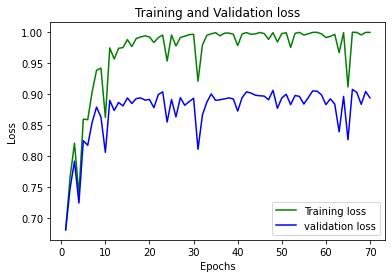

In [11]:
#Setting some hyperparameters and parameters
learning_rate = 1e-3

#Initializing model with nr of features from input
model = Net().to(DEVICE)

#Optimizer and los„s funtion
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()  

#Running training loop on the data with set parameters
training_loop(
    n_epochs=70,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    val_loader = test_loader
)

c:\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1) Train Accuracy: 0.6633354425430298 Test Accuracy: 0.6584280729293823
Epoch 2) Train Accuracy: 0.7638975381851196 Test Accuracy: 0.7483934760093689
Epoch 3) Train Accuracy: 0.8131167888641357 Test Accuracy: 0.7839841842651367
Epoch 4) Train Accuracy: 0.6886945366859436 Test Accuracy: 0.6796836256980896
Epoch 5) Train Accuracy: 0.8415989875793457 Test Accuracy: 0.8047454357147217
Epoch 6) Train Accuracy: 0.871705174446106 Test Accuracy: 0.829955518245697
Epoch 7) Train Accuracy: 0.9261711239814758 Test Accuracy: 0.8655462265014648
Epoch 8) Train Accuracy: 0.9360399842262268 Test Accuracy: 0.8695007562637329
Epoch 9) Train Accuracy: 0.939537763595581 Test Accuracy: 0.877409815788269
Epoch 10) Train Accuracy: 0.9030606150627136 Test Accuracy: 0.8339100480079651
Epoch 11) Train Accuracy: 0.9396626949310303 Test Accuracy: 0.8729609251022339
Epoch 12) Train Accuracy: 0.9367895126342773 Test Accuracy: 0.856154203414917
Epoch 13) Train Accuracy: 0.9806370735168457 Test Accuracy: 0.8907

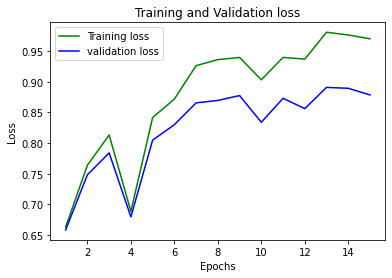

In [12]:
#Renewing our model to run it for more efficient number of epochs
learning_rate = 1e-3

model = Net().to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss() 

training_loop(
    n_epochs=15,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    val_loader = test_loader
)

In [ ]:
# Transfer learning, importing pretrained resnet50 and changing it's last layer to be a simple binary classification
model = models.resnet50(pretrained=True)

## freeze the layers
for param in model.parameters():
    param.requires_grad = False

learning_rate = 1e-3
nr_feat = model.fc.in_features
model.fc = nn.Linear(nr_feat, 1)
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()

#train pretrained
training_loop(
    n_epochs=50,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    val_loader = test_loader
)

In [ ]:
model = models.resnet50(pretrained=True)

## freeze the layers
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()

training_loop(
    n_epochs=10,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    val_loader = test_loader
)